<font size="5">Edge Model</font>

In this notebook, a model gets trained on the Google Speech Command Dataset V2 without the keywords backward, forward, and follow. These three keywords get added later when trained on the Akida neural processor from BrainChip. The code was inspired by the official code from BrainChip (https://doc.brainchipinc.com/examples/edge/plot_1_edge_learning_kws.html).

In [1]:
# Import modules and dependencies

import os
from os import listdir
from os.path import isdir, join
import pathlib

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


import akida
from akida import FullyConnected
from akida import evaluate_sparsity
import cnn2snn
from cnn2snn import check_model_compatibility
from cnn2snn import quantize
from cnn2snn import quantize_layer
from cnn2snn import convert

from keras import Model
from keras.layers import (Input, Reshape, Activation, Flatten, Rescaling, Add, Dropout)

import akida_models
from akida_models import layer_blocks
from akida_models.layer_blocks import conv_block, separable_conv_block, dense_block

from time import time

from math import ceil



In [2]:
# If needed, set seed for experiment reproducibility

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

<font size="5"> 1. Load the Data Set</font>


In [3]:
# Define directories of the data

data_dir = pathlib.Path('data/Modded_Google_wEdge')
data_dir_edge = pathlib.Path('data/Modded_Google_Edge')
edge_dir = pathlib.Path('data/Edge_Categories')

In [4]:
# Print commands

targets = np.array(tf.io.gfile.listdir(str(data_dir)))

targets = targets[targets != 'README.md']

targets = targets[targets != 'follow']
targets = targets[targets != 'forward']
targets = targets[targets != 'backward']

targets_edge = np.array(tf.io.gfile.listdir(str(edge_dir)))

targets = np.append(targets, targets_edge)

print('Known and unknown commands:', targets)
print('Newly added commands for edge learning:', targets_edge)

Known and unknown commands: ['off' 'up' 'down' 'on' 'stop' 'yes' 'right' 'unknown' 'left' 'go' 'no'
 'silence' 'forward' 'follow' 'backward']
Newly added commands for edge learning: ['forward' 'follow' 'backward']


In [5]:
# Define directories, and names of the model and data sets

feature_sets_path = '/home/sebastian/Schreibtisch/Masterarbeit/Audio/'
feature_sets_filename = 'final_stored_files_targets_int_normalized_wedge.npz'
feature_sets_filename_edge = 'final_stored_files_targets_int_normalized_edge.npz'

CNN_model_filename = 'final_CNN_edge_model.h5'
Quantized_model_filename = 'final_quantized_edge_model.h5'
Akida_model_filename = 'final_akida_edge_variable_bits_model.h5'

In [6]:
# Load data sets

feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
feature_sets_edge = np.load(join(feature_sets_path, feature_sets_filename_edge))
print('Feature Sets: ', feature_sets.files)
print('Feature Sets for Edge: ', feature_sets_edge.files)


Feature Sets:  ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']
Feature Sets for Edge:  ['x_train', 'y_train', 'x_val', 'y_val']


In [7]:
# Assign feature sets

x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [8]:
# Assign feature sets for the edge categories
# There is no test set in the data set of the edge categories. 

x_train_edge = feature_sets_edge['x_train']
y_train_edge = feature_sets_edge['y_train']
x_val_edge = feature_sets_edge['x_val']
y_val_edge = feature_sets_edge['y_val']
#x_test_edge = feature_sets_edge['x_test']
#y_test_edge = feature_sets_edge['y_test']

In [9]:
# Look at tensor dimensions

print('x_train shape: ', x_train.shape)
print('x_val shape: ', x_val.shape)
print('x_test shape: ', x_test.shape)
print('x_train_edge shape: ', x_train_edge.shape)
print('x_val_edge shape: ', x_val_edge.shape)
#print('x_test_edge shape: ', x_test_edge.shape)

x_train shape:  (34972, 40, 101)
x_val shape:  (4371, 40, 101)
x_test shape:  (4371, 40, 101)
x_train_edge shape:  (714, 40, 101)
x_val_edge shape:  (85, 40, 101)


Check the dimensions of the data set. 
Is the unknown and silence category roughly 10% (Category 7 and 11)?
In the edge data set, are there only 5 utterances of each new target in the training data. 

In [10]:
# Check training set dimensions of the initial training set, without the keywords
# backward, forward, follow. 

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 2735,
 1.0: 2621,
 2.0: 2880,
 3.0: 2763,
 4.0: 2874,
 5.0: 2972,
 6.0: 2750,
 7.0: 3500,
 8.0: 2783,
 9.0: 2776,
 10.0: 2852,
 11.0: 3466}

In [11]:
# Check training set dimensions of the initial validation set, without the keywords
# backward, forward, follow. 

unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0.0: 340,
 1.0: 340,
 2.0: 348,
 3.0: 358,
 4.0: 353,
 5.0: 347,
 6.0: 335,
 7.0: 438,
 8.0: 343,
 9.0: 360,
 10.0: 349,
 11.0: 460}

In [12]:
# Check training set dimensions of the initial test set, without the keywords
# backward, forward, follow. 

unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 352,
 1.0: 308,
 2.0: 352,
 3.0: 350,
 4.0: 336,
 5.0: 373,
 6.0: 363,
 7.0: 433,
 8.0: 376,
 9.0: 342,
 10.0: 344,
 11.0: 442}

In [13]:
# Check training set dimensions of the data set with the edge categories backward, forward, follow. 

unique_edge, counts_edge = np.unique(y_train_edge, return_counts=True)
dict(zip(unique_edge, counts_edge))

{0.0: 45,
 1.0: 45,
 2.0: 45,
 3.0: 45,
 4.0: 45,
 5.0: 45,
 6.0: 45,
 7.0: 72,
 8.0: 45,
 9.0: 45,
 10.0: 45,
 11.0: 72,
 12.0: 40,
 13.0: 40,
 14.0: 40}

In [14]:
# Check validation set dimensions of the data set with the edge categories backward, forward, follow. 

unique_edge, counts_edge = np.unique(y_val_edge, return_counts=True)
dict(zip(unique_edge, counts_edge))

{0.0: 5,
 1.0: 5,
 2.0: 5,
 3.0: 5,
 4.0: 5,
 5.0: 5,
 6.0: 5,
 7.0: 8,
 8.0: 5,
 9.0: 5,
 10.0: 5,
 11.0: 8,
 12.0: 6,
 13.0: 7,
 14.0: 6}

In [15]:
# Define the number of labels for both data sets. 

num_labels = len(unique)
num_labels_edge = len(unique_edge)
print('number of labels: ', num_labels)
print('number of edge labels: ', num_labels_edge)
#print(x_train.shape)

number of labels:  12
number of edge labels:  15


In [19]:
# CNN for conversion expects (batch, height, width, channels)
# The channels can either be 1 for gray-scaled images or 3 for RGB-images

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)

x_train_edge = x_train_edge.reshape(x_train_edge.shape[0], 
                          x_train_edge.shape[1], 
                          x_train_edge.shape[2], 
                          1)
x_val_edge = x_val_edge.reshape(x_val_edge.shape[0], 
                      x_val_edge.shape[1], 
                      x_val_edge.shape[2], 
                      1)



print('Add dimension to all data: Order Train, Val, Test, Train_edge, Val_edge: ')
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(x_train_edge.shape)
print(x_val_edge.shape)
#print(x_test_edge.shape)


Add dimension to all data: Order Train, Val, Test, Train_edge, Val_edge: 
(34972, 40, 101, 1)
(4371, 40, 101, 1)
(4371, 40, 101, 1)
(714, 40, 101, 1)
(85, 40, 101, 1)


<font size="5">2. Train and Save the CNN-Model</font>

In [20]:
# Define the input shape for the CNN, namely the dimension of 1 MFCC

input_shape = x_test.shape[1:]
print('Input shape of 1 Tensor/MFCC: ', input_shape)

Input shape of 1 Tensor/MFCC:  (40, 101, 1)


In [18]:
# CNN created with the functional API and from akida_models layer_blocks

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)
x = conv_block(x,
               filters=32,
               kernel_size=(3, 3),
               padding='same',
               strides=(2, 2),
               use_bias=False,
               name='conv_0',
               add_batchnorm=True)

x = separable_conv_block(x,
                         filters=32,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_1',
                         add_batchnorm=True)
x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=64,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_2',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=128,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_3',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=128,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_4',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=256,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_5',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=256,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_6',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=512,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_7',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=1024,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_8',
                         pooling='global_avg',
                         add_batchnorm=True)

x = Dropout(0.25)(x)


shape = (1, 1, int(1024))
x = Reshape(shape, name='reshape_1')(x)

x = Flatten()(x)
x = layers.Dense(units = 12, activation='linear', use_bias = True)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

outputs = layers.Activation('softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')

CNN_model.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 101, 1)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 40, 101, 1)        0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 20, 51, 32)        288       
_________________________________________________________________
conv_0_BN (BatchNormalizatio (None, 20, 51, 32)        128       
_________________________________________________________________
conv_0_relu (ReLU)           (None, 20, 51, 32)        0         
_________________________________________________________________
separable_1 (SeparableConv2D (None, 20, 51, 32)        1312      
_________________________________________________________________
separable_1_BN (BatchNormali (None, 20, 51, 32)        12

2022-04-15 19:33:13.202150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 19:33:13.243270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 19:33:13.243430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 19:33:13.243767: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
# Check if model is compatible

print("Model compatible for Akida conversion:", check_model_compatibility(CNN_model))

Model compatible for Akida conversion: True


In [20]:
# Compile the CNN model

CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [21]:
# Train model for 500 epochs and keep the best model measured on the validation accuracy. 

EPOCHS = 500
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

2022-04-15 19:33:33.510254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-15 19:33:35.220936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-04-15 19:33:36.117505: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-15 19:33:36.303208: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1093/1093 [==============================] - 15s 11ms/step - loss: 2.1544 - accuracy: 0.2556 - val_loss: 1.5314 - val_accuracy: 0.4981
Epoch 2/500
1093/1093 [==============================] - 11s 10ms/step - loss: 1.2486 - accuracy: 0.6075 - val_loss: 0.8020 - val_accuracy: 0.7440
Epoch 3/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.9142 - accuracy: 0.7170 - val_loss: 0.5844 - val_accuracy: 0.8229
Epoch 4/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.7936 - accuracy: 0.7540 - val_loss: 0.5315 - val_accuracy: 0.8280
Epoch 5/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.7019 - accuracy: 0.7825 - val_loss: 0.5451 - val_accuracy: 0.8428
Epoch 6/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.6443 - accuracy: 0.8035 - val_loss: 0.3971 - val_accuracy: 0.8742
Epoch 7/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.5984 - accuracy: 0.8164 - val_loss: 0.4038 - val_

1093/1093 [==============================] - 12s 11ms/step - loss: 0.1547 - accuracy: 0.9482 - val_loss: 0.1967 - val_accuracy: 0.9414
Epoch 112/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1484 - accuracy: 0.9502 - val_loss: 0.1965 - val_accuracy: 0.9398
Epoch 113/500
1093/1093 [==============================] - 11s 11ms/step - loss: 0.1462 - accuracy: 0.9507 - val_loss: 0.1990 - val_accuracy: 0.9412
Epoch 114/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1497 - accuracy: 0.9504 - val_loss: 0.1968 - val_accuracy: 0.9403
Epoch 115/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.1468 - accuracy: 0.9509 - val_loss: 0.2048 - val_accuracy: 0.9369
Epoch 116/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1493 - accuracy: 0.9495 - val_loss: 0.1969 - val_accuracy: 0.9414
Epoch 117/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1476 - accuracy: 0.9496 - val_loss: 0

1093/1093 [==============================] - 11s 10ms/step - loss: 0.1230 - accuracy: 0.9583 - val_loss: 0.2121 - val_accuracy: 0.9407
Epoch 167/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.1205 - accuracy: 0.9594 - val_loss: 0.2089 - val_accuracy: 0.9419
Epoch 168/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.1223 - accuracy: 0.9589 - val_loss: 0.1977 - val_accuracy: 0.9435
Epoch 169/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.1174 - accuracy: 0.9605 - val_loss: 0.2061 - val_accuracy: 0.9437
Epoch 170/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1214 - accuracy: 0.9585 - val_loss: 0.2035 - val_accuracy: 0.9391
Epoch 171/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.1181 - accuracy: 0.9594 - val_loss: 0.2105 - val_accuracy: 0.9419
Epoch 172/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1198 - accuracy: 0.9594 - val_loss: 0

1093/1093 [==============================] - 11s 10ms/step - loss: 0.1048 - accuracy: 0.9653 - val_loss: 0.2098 - val_accuracy: 0.9421
Epoch 222/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1039 - accuracy: 0.9652 - val_loss: 0.2100 - val_accuracy: 0.9435
Epoch 223/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1059 - accuracy: 0.9647 - val_loss: 0.2133 - val_accuracy: 0.9417
Epoch 224/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1037 - accuracy: 0.9665 - val_loss: 0.2079 - val_accuracy: 0.9435
Epoch 225/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.1025 - accuracy: 0.9658 - val_loss: 0.2145 - val_accuracy: 0.9419
Epoch 226/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1013 - accuracy: 0.9656 - val_loss: 0.2114 - val_accuracy: 0.9451
Epoch 227/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.1008 - accuracy: 0.9672 - val_loss: 0

1093/1093 [==============================] - 11s 11ms/step - loss: 0.0880 - accuracy: 0.9689 - val_loss: 0.2207 - val_accuracy: 0.9426
Epoch 277/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0884 - accuracy: 0.9697 - val_loss: 0.2174 - val_accuracy: 0.9453
Epoch 278/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0880 - accuracy: 0.9698 - val_loss: 0.2111 - val_accuracy: 0.9412
Epoch 279/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0904 - accuracy: 0.9705 - val_loss: 0.2142 - val_accuracy: 0.9449
Epoch 280/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0891 - accuracy: 0.9696 - val_loss: 0.2099 - val_accuracy: 0.9451
Epoch 281/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0901 - accuracy: 0.9696 - val_loss: 0.2121 - val_accuracy: 0.9421
Epoch 282/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0883 - accuracy: 0.9699 - val_loss: 0

1093/1093 [==============================] - 11s 10ms/step - loss: 0.0798 - accuracy: 0.9739 - val_loss: 0.2257 - val_accuracy: 0.9437
Epoch 332/500
1093/1093 [==============================] - 11s 11ms/step - loss: 0.0827 - accuracy: 0.9718 - val_loss: 0.2156 - val_accuracy: 0.9444
Epoch 333/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0797 - accuracy: 0.9735 - val_loss: 0.2238 - val_accuracy: 0.9435
Epoch 334/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0797 - accuracy: 0.9734 - val_loss: 0.2275 - val_accuracy: 0.9417
Epoch 335/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0791 - accuracy: 0.9725 - val_loss: 0.2289 - val_accuracy: 0.9403
Epoch 336/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0767 - accuracy: 0.9748 - val_loss: 0.2242 - val_accuracy: 0.9433
Epoch 337/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0778 - accuracy: 0.9743 - val_loss: 0

1093/1093 [==============================] - 11s 10ms/step - loss: 0.0733 - accuracy: 0.9755 - val_loss: 0.2172 - val_accuracy: 0.9433
Epoch 387/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0733 - accuracy: 0.9754 - val_loss: 0.2189 - val_accuracy: 0.9451
Epoch 388/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0695 - accuracy: 0.9765 - val_loss: 0.2247 - val_accuracy: 0.9458
Epoch 389/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0744 - accuracy: 0.9762 - val_loss: 0.2199 - val_accuracy: 0.9446
Epoch 390/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0717 - accuracy: 0.9760 - val_loss: 0.2349 - val_accuracy: 0.9423
Epoch 391/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0743 - accuracy: 0.9741 - val_loss: 0.2277 - val_accuracy: 0.9442
Epoch 392/500
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0741 - accuracy: 0.9745 - val_loss: 0

1093/1093 [==============================] - 12s 11ms/step - loss: 0.0677 - accuracy: 0.9772 - val_loss: 0.2319 - val_accuracy: 0.9430
Epoch 442/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0668 - accuracy: 0.9770 - val_loss: 0.2305 - val_accuracy: 0.9426
Epoch 443/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0677 - accuracy: 0.9776 - val_loss: 0.2290 - val_accuracy: 0.9435
Epoch 444/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0680 - accuracy: 0.9775 - val_loss: 0.2566 - val_accuracy: 0.9387
Epoch 445/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0702 - accuracy: 0.9763 - val_loss: 0.2277 - val_accuracy: 0.9446
Epoch 446/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0695 - accuracy: 0.9774 - val_loss: 0.2332 - val_accuracy: 0.9407
Epoch 447/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0655 - accuracy: 0.9769 - val_loss: 0

1093/1093 [==============================] - 11s 10ms/step - loss: 0.0613 - accuracy: 0.9783 - val_loss: 0.2335 - val_accuracy: 0.9437
Epoch 497/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0630 - accuracy: 0.9779 - val_loss: 0.2435 - val_accuracy: 0.9430
Epoch 498/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0613 - accuracy: 0.9791 - val_loss: 0.2328 - val_accuracy: 0.9430
Epoch 499/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0658 - accuracy: 0.9779 - val_loss: 0.2288 - val_accuracy: 0.9446
Epoch 500/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0618 - accuracy: 0.9796 - val_loss: 0.2434 - val_accuracy: 0.9403


/tmp/ipykernel_37066/897927363.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_37066/897927363.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_37066/897927363.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_37066/897927363.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take p

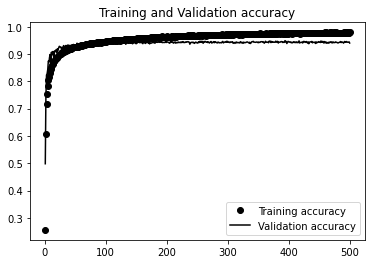

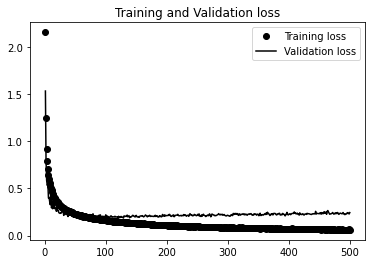

In [22]:
# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [23]:
# Print performance of the CNN model 

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy on test set of CNN:', score[1] * 100,'%')

Accuracy on train set of CNN: 99.97140765190125 %
Accuracy on validation set of CNN: 94.89819407463074 %
Accuracy on test set of CNN: 93.93731355667114 %


In [24]:
# Save CNN-Model

models.save_model(CNN_model, CNN_model_filename)

<font size="5">3. Quantize the CNN-Model</font>

Quantize the model first with 4-bit activations, then with 1-bit activations.
These models are then merged in such a way that the final model employs all layers of the quantized model with 4-bit activations, with the exception of the layer preceding the last layer, which uses layers of the 1-bit quantized model.
This was done to achieve the maximum bit-width while still allowing for on-chip edge learning.  


In [25]:
# Quantize the CNN-model with 4-Bit activations

quantized_model4 = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model4.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 101, 1)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 40, 101, 1)        0         
_________________________________________________________________
conv_0 (QuantizedConv2D)     (None, 20, 51, 32)        320       
_________________________________________________________________
conv_0_relu (ActivationDiscr (None, 20, 51, 32)        0         
_________________________________________________________________
separable_1 (QuantizedSepara (None, 20, 51, 32)        1344      
_________________________________________________________________
separable_1_relu (Activation (None, 20, 51, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 51, 32)        0 

In [26]:
# Quantize the CNN-model with 1-Bit activations

quantized_model1 = quantize(quantized_model4,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=1)
quantized_model1.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 101, 1)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 40, 101, 1)        0         
_________________________________________________________________
conv_0 (QuantizedConv2D)     (None, 20, 51, 32)        320       
_________________________________________________________________
conv_0_relu (ActivationDiscr (None, 20, 51, 32)        0         
_________________________________________________________________
separable_1 (QuantizedSepara (None, 20, 51, 32)        1344      
_________________________________________________________________
separable_1_relu (Activation (None, 20, 51, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 51, 32)        0 

In [28]:
# Merge both quantized models

quantized_model = models.Sequential()

inputs_layer = Input(shape=input_shape)
quantized_model.add(inputs_layer)

for i in range(1, 25, 1):
    layer = quantized_model4.get_layer(index=i)
    quantized_model.add(layer)

layer1 = quantized_model1.get_layer('separable_8')
layer2 = quantized_model1.get_layer('separable_8_global_avg')
layer3 = quantized_model1.get_layer('separable_8_relu')
layer4 = quantized_model1.get_layer('dropout_7')
layer5 = quantized_model4.get_layer('reshape_1')
layer6 = quantized_model4.get_layer('flatten')
layer7 = quantized_model4.get_layer('dense')
layer8 = quantized_model4.get_layer('re_lu')
layer9 = quantized_model4.get_layer('activation')



quantized_model.add(layer1)
quantized_model.add(layer2)
quantized_model.add(layer3)
quantized_model.add(layer4)
quantized_model.add(layer5)
quantized_model.add(layer6)
quantized_model.add(layer7)
quantized_model.add(layer8)
quantized_model.add(layer9)
quantized_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 40, 101, 1)        0         
_________________________________________________________________
conv_0 (QuantizedConv2D)     (None, 20, 51, 32)        320       
_________________________________________________________________
conv_0_relu (ActivationDiscr (None, 20, 51, 32)        0         
_________________________________________________________________
separable_1 (QuantizedSepara (None, 20, 51, 32)        1344      
_________________________________________________________________
separable_1_relu (Activation (None, 20, 51, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 51, 32)        0         
_________________________________________________________________
separable_2 (QuantizedSepara (None, 10, 26, 64)       

In [29]:
# Check model accuracy after quantization

quantized_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

In [30]:
# Print performance of the quantized model before quantization aware training

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy on test set of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 61.78085207939148 %
Accuracy on validation set of quantized CNN: 57.08075761795044 %
Accuracy on test set of quantized CNN: 55.73095679283142 %


In [31]:
EPOCHS = 100
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback])

quantized_model.load_weights(checkpoint_filepath)

Epoch 1/100
1093/1093 [==============================] - 19s 15ms/step - loss: 0.1910 - accuracy: 0.9450 - val_loss: 0.2378 - val_accuracy: 0.9382
Epoch 2/100
1093/1093 [==============================] - 17s 16ms/step - loss: 0.1545 - accuracy: 0.9576 - val_loss: 0.2410 - val_accuracy: 0.9382
Epoch 3/100
1093/1093 [==============================] - 17s 16ms/step - loss: 0.1417 - accuracy: 0.9613 - val_loss: 0.2341 - val_accuracy: 0.9378
Epoch 4/100
1093/1093 [==============================] - 17s 16ms/step - loss: 0.1468 - accuracy: 0.9596 - val_loss: 0.2384 - val_accuracy: 0.9375
Epoch 5/100
1093/1093 [==============================] - 17s 15ms/step - loss: 0.1420 - accuracy: 0.9606 - val_loss: 0.2397 - val_accuracy: 0.9321
Epoch 6/100
1093/1093 [==============================] - 17s 16ms/step - loss: 0.1384 - accuracy: 0.9616 - val_loss: 0.2330 - val_accuracy: 0.9417
Epoch 7/100
1093/1093 [==============================] - 17s 15ms/step - loss: 0.1344 - accuracy: 0.9636 - val_loss: 0

In [32]:
# Print performance of the quantized model after quantization aware training

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy on test set of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 99.85131025314331 %
Accuracy on validation set of quantized CNN: 94.21185255050659 %
Accuracy on test set of quantized CNN: 93.50262880325317 %


/tmp/ipykernel_37066/897927363.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_37066/897927363.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_37066/897927363.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_37066/897927363.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take p

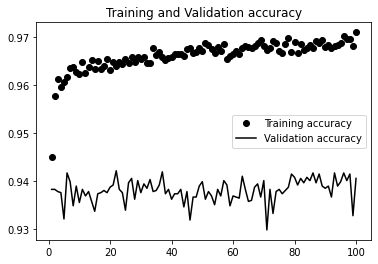

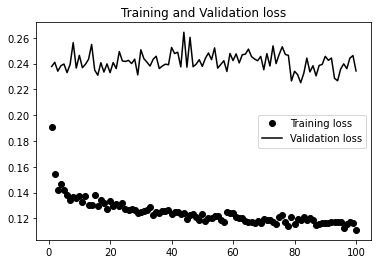

In [33]:
# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [34]:
# Save quantized-model

models.save_model(quantized_model, Quantized_model_filename)

In [16]:
####### If pretrained the quantized model can be loaded ########

quantized_model = cnn2snn.load_quantized_model('final_quantized_edge_model.h5')

2022-04-15 21:52:30.377597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 21:52:30.535312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 21:52:30.535468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 21:52:30.535976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<font size="5">4. Akida Model Conversion</font>

In [57]:
#  Convert to an Akida model

akida_model = convert(quantized_model)
akida_model.summary()

                 Model Summary                 
_______________________________________________
Input shape   Output shape  Sequences  Layers
[40, 101, 1]  [1, 1, 12]    1          10    
_______________________________________________

                SW/conv_0-dense (Software)                 
___________________________________________________________
Layer (type)             Output shape   Kernel shape     
conv_0 (InputConv.)      [51, 20, 32]   (3, 3, 1, 32)    
___________________________________________________________
separable_1 (Sep.Conv.)  [51, 20, 32]   (3, 3, 32, 1)    
___________________________________________________________
                                        (1, 1, 32, 32)   
___________________________________________________________
separable_2 (Sep.Conv.)  [26, 10, 64]   (3, 3, 32, 1)    
___________________________________________________________
                                        (1, 1, 32, 64)   
_______________________________________________________

In [41]:
# Print performance of the final Akida model

results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')


results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_test)
accuracy = (y_test == results).mean()


print('SNN accuracy on test set after conversion:', accuracy * 100,'%')

SNN accuracy on training set after conversion: 99.84845018872241 %
SNN accuracy on validation set after conversion: 94.00594829558453 %
SNN accuracy on test set after conversion: 93.4339967970716 %


<font size="5">5. Edge Learning</font>

This is the final section of the notebook.
The results of this section are not included in the master thesis since edge learning was done on chip, namely the BrainChip development kit.
However, the code was kept in to demonstrate the entire procedure. 

In [22]:
# Estimate the hyperparameter "number of weights".
# This hyperparameter describes the number of weights assigned for each neuron in the edge layer. 
# As described in the MetaTF documentation 10% of the training set is used to evaluate the sparsity. 
# Code Source: https://doc.brainchipinc.com/examples/edge/plot_1_edge_learning_kws.html

num_samples = ceil(0.1 * x_train.shape[0])
sparsities = evaluate_sparsity(akida_model, x_train[:num_samples])

# Retrieve the number of output spikes from the feature extractor output
output_density = 1 - sparsities[akida_model.get_layer('separable_8')]
avg_spikes = quantized_model.get_layer('separable_8').output_shape[-1] * output_density
print(f"Average number of spikes: {avg_spikes}")

# Fix the number of weights to 1.2 times the average number of output spikes
num_weights = int(1.2 * avg_spikes)
print("The number of weights is then set to:", num_weights)

Average number of spikes: 250.38078902229847
The number of weights is then set to: 300


In [25]:
# Hyperparameters search for the hyperparameter "neurons per class".

neurons_per_class = [2, 4, 8, 16, 32, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 350, 400, 450, 500]

for idx, n in enumerate(neurons_per_class):
    
    akida_model_test = convert(quantized_model)

    akida_model_test.pop_layer()
    layer_fc = FullyConnected(name='akida_edge_layer',
                              units=num_labels * n,
                              activation=False)
    akida_model_test.add(layer_fc)

    #akida_model_test.summary()
    
    akida_model_test.compile(num_weights=num_weights,
                     num_classes=num_labels,
                     learning_competition=0.1)

    batch_size = 16
    preds_ak = np.zeros(y_val.shape[0])
    num_batches_val = ceil(x_val.shape[0] / batch_size)
    num_batches = ceil(x_train.shape[0] / batch_size)
    
    
    start = time()
    for i in range(num_batches):
        s = slice(i * batch_size, (i + 1) * batch_size)
        akida_model_test.fit(x_train[s], y_train[s].astype(np.int32))
    end = time()
    
    preds_val_ak = akida_model_test.predict(x_val, num_classes=num_labels)
    acc_val_ak = np.sum(preds_val_ak == y_val) / y_val.shape[0]
    print(f'Akida inference {len(x_train)} MFCC took {end-start:.2f} with neurons per class: s.\n', n)
    print(f"Akida validation set accuracy on initial data set: {100 * acc_val_ak:.2f} %", 'with neurons per class: ',n)
    del akida_model_test

Akida inference 34972 MFCC took 53.96 with neurons per class: s.
 2
Akida validation set accuracy on initial data set: 93.50 % with neurons per class:  2
Akida inference 34972 MFCC took 53.94 with neurons per class: s.
 4
Akida validation set accuracy on initial data set: 93.57 % with neurons per class:  4
Akida inference 34972 MFCC took 55.16 with neurons per class: s.
 8
Akida validation set accuracy on initial data set: 93.48 % with neurons per class:  8
Akida inference 34972 MFCC took 54.30 with neurons per class: s.
 16
Akida validation set accuracy on initial data set: 93.69 % with neurons per class:  16
Akida inference 34972 MFCC took 54.80 with neurons per class: s.
 32
Akida validation set accuracy on initial data set: 93.78 % with neurons per class:  32
Akida inference 34972 MFCC took 54.84 with neurons per class: s.
 40
Akida validation set accuracy on initial data set: 93.85 % with neurons per class:  40
Akida inference 34972 MFCC took 56.31 with neurons per class: s.
 50
A

In [58]:
# Replace the last layer with the edge layer. 
# The edge layer is simply a fully connected layer.
# Code Source: https://doc.brainchipinc.com/examples/edge/plot_1_edge_learning_kws.html

num_neurons_per_class = 500

akida_model.pop_layer()
layer_fc = FullyConnected(name='akida_edge_layer',
                          units=num_labels * num_neurons_per_class,
                          activation=False)
akida_model.add(layer_fc)

In [59]:
# Print the performance of the Akida model before STDP

results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after edge layer replacement:', accuracy * 100,'%')


results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after edge layer replacement:', accuracy * 100,'%')

results = akida_model.predict(x_test)
accuracy = (y_test == results).mean()


print('SNN accuracy on test set after edge layer replacement:', accuracy * 100,'%')

SNN accuracy on training set after edge layer replacement: 7.820542148004117 %
SNN accuracy on validation set after edge layer replacement: 7.778540379775794 %
SNN accuracy on test set after edge layer replacement: 8.053077099062 %


In [60]:
# Compile Akida model with hyperparameters

akida_model.compile(num_weights=num_weights,
                 num_classes=num_labels,
                 learning_competition=0.1)
akida_model.summary()

                 Model Summary                 
_______________________________________________
Input shape   Output shape  Sequences  Layers
[40, 101, 1]  [1, 1, 6000]  1          10    
_______________________________________________

            SW/conv_0-akida_edge_layer (Software)             
______________________________________________________________
Layer (type)               Output shape   Kernel shape      
conv_0 (InputConv.)        [51, 20, 32]   (3, 3, 1, 32)     
______________________________________________________________
separable_1 (Sep.Conv.)    [51, 20, 32]   (3, 3, 32, 1)     
______________________________________________________________
                                          (1, 1, 32, 32)    
______________________________________________________________
separable_2 (Sep.Conv.)    [26, 10, 64]   (3, 3, 32, 1)     
______________________________________________________________
                                          (1, 1, 32, 64)    
___________________

In [61]:
# Train the Akida model
# Code Source: https://doc.brainchipinc.com/examples/edge/plot_1_edge_learning_kws.html

batch_size = 16
preds_ak = np.zeros(y_val.shape[0])
num_batches_val = ceil(x_val.shape[0] / batch_size)

# Train the last layer using Akida `fit` method
print(f"Akida learning with {num_labels} classes... \
        (this step can take a few minutes)")
num_batches = ceil(x_train.shape[0] / batch_size)
start = time()
for i in range(num_batches):
    s = slice(i * batch_size, (i + 1) * batch_size)
    akida_model.fit(x_train[s], y_train[s].astype(np.int32))
end = time()

print(f"Elapsed time for Akida training: {end-start:.2f} s")

Akida learning with 12 classes...         (this step can take a few minutes)
Elapsed time for Akida training: 70.51 s


In [62]:
# Print the performance of the Akida model on the training set. 

preds_val_ak = akida_model.predict(x_train, num_classes=num_labels)
acc_val_ak = np.sum(preds_val_ak == y_train) / y_train.shape[0]
print(f"Akida train set accuracy: {100 * acc_val_ak:.2f} %")

Akida train set accuracy: 99.05 %


In [63]:
# Print the performance of the Akida model on the validation set. 

preds_val_ak = np.zeros(y_val.shape[0])
for i in range(num_batches_val):
    s = slice(i * batch_size, (i + 1) * batch_size)
    preds_val_ak[s] = akida_model.predict(x_val[s], num_classes=num_labels)

acc_val_ak = np.sum(preds_val_ak == y_val) / y_val.shape[0]
print(f"Akida validation set accuracy: {100 * acc_val_ak:.2f} %")

Akida validation set accuracy: 93.94 %


In [64]:
# Print the performance of the Akida model on the test set. 


preds_val_ak = np.zeros(y_test.shape[0])
for i in range(num_batches_val):
    s = slice(i * batch_size, (i + 1) * batch_size)
    preds_val_ak[s] = akida_model.predict(x_test[s], num_classes=num_labels)

acc_val_ak = np.sum(preds_val_ak == y_test) / y_test.shape[0]
print(f"Akida test set accuracy: {100 * acc_val_ak:.2f} %")

Akida test set accuracy: 93.27 %


In [65]:
# Add 3 new classes/keywords

akida_model.add_classes(3)

# Train the Akida on the new keywords
# Code Source: https://doc.brainchipinc.com/examples/edge/plot_1_edge_learning_kws.html

print("\nEdge learning with 3 new classes ...")
start = time()
akida_model.fit(x_train_edge, y_train_edge.astype(np.int32))
end = time()
print(f"Elapsed time for Akida edge learning: {end-start:.2f} s")


Edge learning with 3 new classes ...
Elapsed time for Akida edge learning: 1.08 s


In [66]:
# Print the performance of the Akida model on the initial data set

preds_val_ak = akida_model.predict(x_train, num_classes=num_labels_edge)
acc_val_ak = np.sum(preds_val_ak == y_train) / y_train.shape[0]
print(f"Akida train set accuracy on old data set: {100 * acc_val_ak:.2f} %")
preds_val_ak = akida_model.predict(x_val, num_classes=num_labels_edge)
acc_val_ak = np.sum(preds_val_ak == y_val) / y_val.shape[0]
print(f"Akida validation set accuracy on old data set: {100 * acc_val_ak:.2f} %")
preds_val_ak = akida_model.predict(x_test, num_classes=num_labels_edge)
acc_val_ak = np.sum(preds_val_ak == y_test) / y_test.shape[0]
print(f"Akida test set accuracy on old data set: {100 * acc_val_ak:.2f} %")

Akida train set accuracy on old data set: 99.04 %
Akida validation set accuracy on old data set: 93.87 %
Akida test set accuracy on old data set: 93.21 %


In [67]:
# Print the performance of the Akida model on the edge data set

preds_val_ak = akida_model.predict(x_train_edge, num_classes=num_labels_edge)
acc_val_ak = np.sum(preds_val_ak == y_train_edge) / y_train_edge.shape[0]
print(f"Akida training set accuracy on new data set: {100 * acc_val_ak:.2f} %")
preds_val_ak = akida_model.predict(x_val_edge, num_classes=num_labels_edge)
acc_val_ak = np.sum(preds_val_ak == y_val_edge) / y_val_edge.shape[0]
print(f"Akida validation set accuracy on new data set: {100 * acc_val_ak:.2f} %")

Akida training set accuracy on new data set: 96.78 %
Akida validation set accuracy on new data set: 90.59 %
